In [6]:
import os
import clip
import torch
from torchvision import transforms, models

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import argparse
from omegaconf import OmegaConf

import json

from datasets import *
device = "cuda" if torch.cuda.is_available() else "cpu"
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import seaborn as sn

from columnar import columnar
from nltk.corpus import wordnet as wn

import importlib
import datasets #import the module here, so that it can be reloaded.
importlib.reload(datasets)
from datasets import *

In [7]:
def clip_zero_shot(
    loader,
    classes,
    zeroshot_weights,
    clip_model_name="ViT-B/32",
):

    global clip_model, clip_preprocess
    device = "cuda" if torch.cuda.is_available() else "cpu"

    def accuracy(output, target, topk=(1,)):
        pred = output.topk(max(topk), 1, True, True)[1].t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        return [
            float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy())
            for k in topk
        ]

    # lazy load
    if clip_model == None:
        clip_model, clip_preprocess = clip.load(clip_model_name, device)
        
    per_class_accuracy_top1 = { k:[0,0, classes[k]] for k in range(102)} # correct, total, class_name
    per_class_accuracy_top5 = { k:[0,0, classes[k]] for k in range(102)} 

    with torch.no_grad():
        top1, top5, n = 0.0, 0.0, 0.0
        for i , (images, target) in enumerate(tqdm(loader)):
            images = images.cuda()
            target = target.cuda()

            # predict
            image_features = clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = 100.0 * image_features @ zeroshot_weights

            # measure accuracy
            acc1, acc5 = accuracy(logits, target, topk=(1, 5))
            top1 += acc1
            top5 += acc5
            n += images.size(0)
            
            per_class_accuracy_top1[target.cpu().detach().numpy()[0]][0]+= acc1
            per_class_accuracy_top1[target.cpu().detach().numpy()[0]][1]+= 1

    top1 = (top1 / n) * 100
    top5 = (top5 / n) * 100

    return top1, per_class_accuracy_top1

In [8]:
dataset_obj = Flowers102(4, 1)
clip_model, clip_preprocess = clip.load("ViT-B/32", )
train_loader, _ = dataset_obj.get_train_loaders(transform_fn=clip_preprocess)
test_loader = dataset_obj.get_test_loader(transform_fn=clip_preprocess)

### Class names - Simple Phrases (Baseline)

In [9]:
phrase_file = "/nethome/bdevnani3/vis_lang/efficient_finetuning/configs/phrases/flowers.txt"

templates = []
with open(phrase_file) as f:
    templates = [line for line in f]
    
    def zeroshot_classifier(classnames, templates):
        with torch.no_grad():
            zeroshot_weights = []
            for classname in tqdm(classnames):
                texts = [
                    template.format(classname) for template in templates
                ]  # format with class
                texts = clip.tokenize(texts).cuda()  # tokenize
                class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
                class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
                class_embedding = class_embeddings.mean(dim=0)
                class_embedding /= class_embedding.norm()
                zeroshot_weights.append(class_embedding)
            zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
        return zeroshot_weights

baseline_zw = zeroshot_classifier(dataset_obj.classes,templates)

baseline_czs = clip_zero_shot(
    test_loader,
    dataset_obj.classes,
    baseline_zw
)
print(baseline_czs[0])

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

64.83516483516483


0.6539285109670552


<AxesSubplot:>

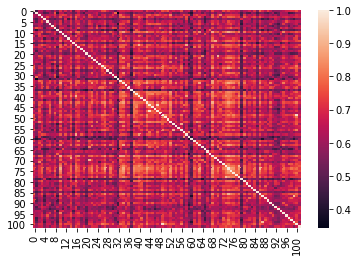

In [10]:
matrix = cosine_similarity(baseline_zw.cpu().detach().numpy().T)
print(matrix.mean())
sn.heatmap(matrix)

In [11]:
#Per class performance
import matplotlib.pyplot as plt
def per_class_performance(d, print_out=True):
    x = []
    labels = []
    corr = []
    tot = []
    for el in d:
        x.append((d[el][0]*100)/d[el][1])
        labels.append(d[el][2])
        corr.append(d[el][0])
        tot.append(d[el][1])
    idx = np.argsort(x)
    x = np.array(x)[idx]
    labels = np.array(labels)[idx]
    corr = np.array(corr)[idx]
    tot = np.array(tot)[idx]
    out = {}
    for l,per,c,t in zip(labels,x,corr,tot):
        out[l] = [np.around(per,5),int(c),int(t)]
    if print_out:
        table = columnar([[l, o[0], o[1], o[2]] for l,o in out.items()], ["Class Name", "Accuracy(%)", "Num Correct", "Total"])
        print(table)
    return out
baseline_pcp = per_class_performance(baseline_czs[1])


|-------------------------|-----------|-----------|-----|
|Class Name               |Accuracy(%)|Num Correct|Total|
|=======================================================|
|pelargonium              |0.0        |0          |7    |
|-------------------------|-----------|-----------|-----|
|love in the mist         |0.0        |0          |8    |
|-------------------------|-----------|-----------|-----|
|silverbush               |0.0        |0          |5    |
|-------------------------|-----------|-----------|-----|
|great masterwort         |0.0        |0          |8    |
|-------------------------|-----------|-----------|-----|
|prince of wales feathers |0.0        |0          |3    |
|-------------------------|-----------|-----------|-----|
|bolero deep blue         |0.0        |0          |3    |
|-------------------------|-----------|-----------|-----|
|hard-leaved pocket orchid|0.0        |0          |5    |
|-------------------------|-----------|-----------|-----|
|sword lily   

In [12]:
def relative_per_class_performance(d1,d2, print_out=True):
    "Positive value means d1 did better"
    x1 = []
    labels = []
    x2 = []
    tot_num_labels_difference = 0
    for el in d1:
        x1.append(((d1[el][0]-d2[el][0])*100)/(d2[el][0]+0.0000001))
        labels.append(d1[el][2])
        num_labels_difference = d1[el][0]
        num_labels_difference -= d2[el][0]
        x2.append(num_labels_difference)
        tot_num_labels_difference += num_labels_difference
        
#         x2.append((d2[el][0]*100)/d2[el][1])
        
#     final = np.array(x1)-np.array(x2)
    idx = np.argsort(x1)
    x1 = np.array(x1)[idx]
    x2 = np.array(x2)[idx]
    labels = np.array(labels)[idx]
    out = {}
    for l,per,num_per in zip(labels,x1,x2):
        if per > 100:
            per = 100
        out[l] = np.around(per,decimals=5), num_per
    if print_out:
        table = columnar([[x,out[x][0],out[x][1]] for x in out], ["Class Name", "Relative Accuracy(%)", "Difference in Num of Labels"])
        print(table)
    return out, tot_num_labels_difference


### Class names - Wikipedia Phrases

In [8]:
phrase_file = "/nethome/bdevnani3/vis_lang/efficient_finetuning/configs/phrases/flowers_wikipedia.txt"

templates = []
with open(phrase_file) as f:
    templates = [line for line in f]
    
    def zeroshot_classifier(classnames, templates):
        with torch.no_grad():
            zeroshot_weights = []
            for classname in tqdm(classnames):
                texts = [
                    template.format(classname) for template in templates
                ]  # format with class
                texts = clip.tokenize(texts).cuda()  # tokenize
                class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
                class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
                class_embedding = class_embeddings.mean(dim=0)
                class_embedding /= class_embedding.norm()
                zeroshot_weights.append(class_embedding)
            zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
        return zeroshot_weights

wikiphrases_zw = zeroshot_classifier(dataset_obj.classes,templates)

wikiphrases_czs = clip_zero_shot(
    test_loader,
    dataset_obj.classes,
    wikiphrases_zw
)
print(wikiphrases_czs[0])

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

47.985347985347985


0.8622800144164053


<AxesSubplot:>

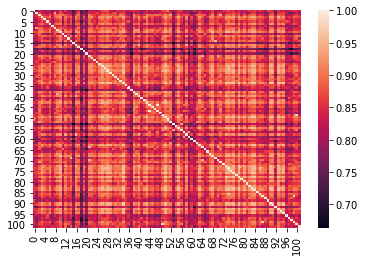

In [30]:
matrix = cosine_similarity(wikiphrases_zw.cpu().detach().numpy().T)
print(matrix.mean())
sn.heatmap(matrix)

In [31]:
# Absolute perf
wikiphrases_absolute_perf = per_class_performance(wikiphrases_czs[1])

|-------------------------|-----------|-----------|-----|
|Class Name               |Accuracy(%)|Num Correct|Total|
|=======================================================|
|wild pansy               |0.0        |0          |8    |
|-------------------------|-----------|-----------|-----|
|thorn apple              |0.0        |0          |13   |
|-------------------------|-----------|-----------|-----|
|canterbury bells         |0.0        |0          |2    |
|-------------------------|-----------|-----------|-----|
|sweet william            |0.0        |0          |14   |
|-------------------------|-----------|-----------|-----|
|tree poppy               |0.0        |0          |4    |
|-------------------------|-----------|-----------|-----|
|garden phlox             |0.0        |0          |6    |
|-------------------------|-----------|-----------|-----|
|love in the mist         |0.0        |0          |8    |
|-------------------------|-----------|-----------|-----|
|mexican aster

In [36]:
# Relative perf
wikiphrases_relative_perf = relative_per_class_performance(wikiphrases_czs[1], baseline_czs[1])
print(wikiphrases_relative_perf[1])

|-------------------------|--------------------|---------------------------|
|Class Name               |Relative Accuracy(%)|Difference in Num of Labels|
|==========================================================================|
|clematis                 |-100.0              |-17.0                      |
|-------------------------|--------------------|---------------------------|
|lotus                    |-100.0              |-12.0                      |
|-------------------------|--------------------|---------------------------|
|hibiscus                 |-100.0              |-12.0                      |
|-------------------------|--------------------|---------------------------|
|sweet william            |-100.0              |-10.0                      |
|-------------------------|--------------------|---------------------------|
|wild pansy               |-100.0              |-8.0                       |
|-------------------------|--------------------|---------------------------|

### Class names + Wordnet Synonyms - Simple Phrases

In [33]:
phrase_file = "/nethome/bdevnani3/vis_lang/efficient_finetuning/configs/phrases/flowers.txt"

templates = []
with open(phrase_file) as f:
    templates = [line for line in f]
    
def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        i = 0
        for cs in tqdm(classnames):
            syns = Flowers102.wordnet_synonyms[cs] + [cs]
            texts = []
            for classname in syns:
                texts.extend([
                    template.format(classname) for template in templates
                ])  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

wordnetsyns_zw = zeroshot_classifier(dataset_obj.classes,templates)

wordnetsyns_czs = clip_zero_shot(
    test_loader,
    dataset_obj.classes,
    wordnetsyns_zw
)
print(wordnetsyns_czs[0])

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

58.852258852258856


0.7325593946506161


<AxesSubplot:>

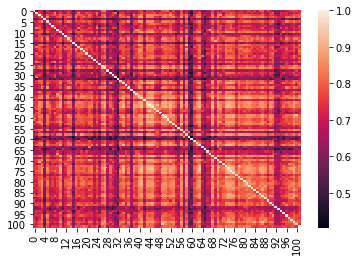

In [34]:
matrix = cosine_similarity(wordnetsyns_zw.cpu().detach().numpy().T)
print(matrix.mean())
sn.heatmap(matrix)

In [35]:
# Which are the lowest performing classes? 
wordnetsyns_relative_perf = relative_per_class_performance(wordnetsyns_czs[1], baseline_czs[1])
print(wordnetsyns_relative_perf[1])

|-------------------------|--------------------|---------------------------|
|Class Name               |Relative Accuracy(%)|Difference in Num of Labels|
|==========================================================================|
|water lily               |-100.0              |-25.0                      |
|-------------------------|--------------------|---------------------------|
|alpine sea holly         |-100.0              |-4.0                       |
|-------------------------|--------------------|---------------------------|
|barbeton daisy           |-100.0              |-3.0                       |
|-------------------------|--------------------|---------------------------|
|fire lily                |-99.99999           |-1.0                       |
|-------------------------|--------------------|---------------------------|
|carnation                |-99.99999           |-1.0                       |
|-------------------------|--------------------|---------------------------|

In [38]:
# Are they correlated with the ones we added synonyms for?
tups = []
for cs in Flowers102.wordnet_synonyms:
    if len(Flowers102.wordnet_synonyms[cs]) > 0:
        tups.append((cs, len(Flowers102.wordnet_synonyms[cs]), wordnetsyns_relative_perf[0][cs]))

tups.sort(key=lambda tup: tup[1])
tups = [list(t) for t in tups]

table = columnar(tups, ["Class Name", "Number of Synonyms", "Performance relative to Baseline(% diff, num labels)"])
print(table)
print(np.mean([t[2] for t in tups]))

|-----------------|------------------|----------------------------------------------------|
|Class Name       |Number of Synonyms|Performance relative to Baseline(% diff, num labels)|
|=========================================================================================|
|magnolia         |2                 |(-25.0, -1.0)                                       |
|-----------------|------------------|----------------------------------------------------|
|globe thistle    |3                 |(0.0, 0.0)                                          |
|-----------------|------------------|----------------------------------------------------|
|snapdragon       |3                 |(14.28571, 1.0)                                     |
|-----------------|------------------|----------------------------------------------------|
|grape hyacinth   |3                 |(0.0, 0.0)                                          |
|-----------------|------------------|------------------------------------------

### Class names - Wordnet Definitions

In [39]:
def generate_definition_set(word):
    try:
        synset = wn.synset(word+".n.01")
        return synset.definition()
    except:
        return ""
d_defs = {}
for c in dataset_obj.classes:
    d_defs[c] = generate_definition_set(c)

In [149]:
d_defs

{'pink primrose': '',
 'globe thistle': '',
 'blanket flower': '',
 'trumpet creeper': '',
 'blackberry lily': '',
 'snapdragon': 'a garden plant of the genus Antirrhinum having showy white or yellow or crimson flowers resembling the face of a dragon',
 "colt's foot": '',
 'king protea': '',
 'spear thistle': '',
 'yellow iris': '',
 'globe-flower': '',
 'purple coneflower': '',
 'peruvian lily': '',
 'balloon flower': '',
 'hard-leaved pocket orchid': '',
 'giant white arum lily': '',
 'fire lily': '',
 'pincushion flower': '',
 'fritillary': 'any liliaceous plant of the genus Fritillaria having nodding variously colored flowers',
 'red ginger': '',
 'grape hyacinth': '',
 'corn poppy': '',
 'prince of wales feathers': '',
 'stemless gentian': '',
 'artichoke': 'Mediterranean thistlelike plant widely cultivated for its large edible flower head',
 'canterbury bells': '',
 'sweet william': '',
 'carnation': 'Eurasian plant with pink to purple-red spice-scented usually double flowers; wi

In [40]:
phrase_file = "/nethome/bdevnani3/vis_lang/efficient_finetuning/configs/phrases/flowers.txt"

templates = []
with open(phrase_file) as f:
    templates = [line for line in f]

In [50]:
def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            if len(d_defs[classname]) > 0:
                texts = [
                    f"{classname} is {d_defs[classname]}"
                ]
                print(texts)
                texts.extend([template.format(classname) for template in templates])
            else:
                texts = [
                    template.format(classname) for template in templates
                ]  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

wordnetdefs_zw = zeroshot_classifier(dataset_obj.classes,templates)

wordnetdefs_czs = clip_zero_shot(
    test_loader,
    dataset_obj.classes,
    wordnetdefs_zw
)
print(wordnetdefs_czs[0])

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

65.07936507936508


0.6519127773079357


<AxesSubplot:>

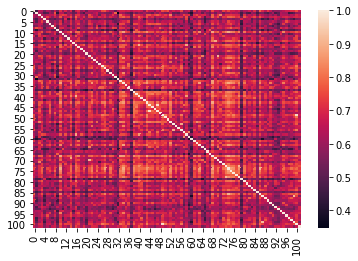

In [51]:
matrix = cosine_similarity(wordnetdefs_zw.cpu().detach().numpy().T)
print(matrix.mean())
sn.heatmap(matrix)

In [52]:
wordnetdefs_relative_perf = relative_per_class_performance(wordnetdefs_czs[1], baseline_czs[1])
print(wordnetdefs_relative_perf[1])

|-------------------------|--------------------|---------------------------|
|Class Name               |Relative Accuracy(%)|Difference in Num of Labels|
|==========================================================================|
|tree mallow              |-50.0               |-1.0                       |
|-------------------------|--------------------|---------------------------|
|barbeton daisy           |-33.33333           |-1.0                       |
|-------------------------|--------------------|---------------------------|
|blanket flower           |-28.57143           |-2.0                       |
|-------------------------|--------------------|---------------------------|
|water lily               |-28.0               |-7.0                       |
|-------------------------|--------------------|---------------------------|
|pink primrose            |-25.0               |-1.0                       |
|-------------------------|--------------------|---------------------------|

In [55]:
# Is the performance correlated with the terms we added definitions for?
tups = []
for cs in d_defs:
    if len(d_defs[cs]) > 0:
        tups.append((cs, wordnetdefs_relative_perf[0][cs]))

tups.sort(key=lambda tup: tup[1][0])
tups = [list(t) for t in tups]

table = columnar(tups, ["Class Name", "Number of Synonyms", "Performance relative to Baseline(% diff, num labels)"])
print(table)
print(np.mean([t[1][1] for t in tups]))

|-------------|------------------|
|Class Name   |Number of Synonyms|
|================================|
|snapdragon   |(0.0, 0.0)        |
|-------------|------------------|
|fritillary   |(0.0, 0.0)        |
|-------------|------------------|
|artichoke    |(0.0, 0.0)        |
|-------------|------------------|
|carnation    |(0.0, 0.0)        |
|-------------|------------------|
|daffodil     |(0.0, 0.0)        |
|-------------|------------------|
|poinsettia   |(0.0, 0.0)        |
|-------------|------------------|
|marigold     |(0.0, 0.0)        |
|-------------|------------------|
|buttercup    |(0.0, 0.0)        |
|-------------|------------------|
|sunflower    |(0.0, 0.0)        |
|-------------|------------------|
|pelargonium  |(0.0, 0.0)        |
|-------------|------------------|
|geranium     |(0.0, 0.0)        |
|-------------|------------------|
|silverbush   |(0.0, 0.0)        |
|-------------|------------------|
|windflower   |(0.0, 0.0)        |
|-------------|-----

### Class names - Wikipedia Prompts per class

In [56]:
phrase_file = "/nethome/bdevnani3/vis_lang/efficient_finetuning/configs/phrases/flowers.txt"

templates = []
with open(phrase_file) as f:
    templates = [line for line in f]

In [139]:
wikipedia_phrase_file = "/nethome/bdevnani3/vis_lang/efficient_finetuning/notebooks/wikipedia_flowers_prompts.json"

f = open(wikipedia_phrase_file)
js = json.load(f)
wiki_class_templates = {c:[] for c in dataset_obj.classes}
for c in dataset_obj.classes:
    for i in range(len(js[c])):
        sen = js[c][i].replace("\n", "").replace("(", "").replace(")", "").replace("\"", "").replace("  ", " ").replace(" .",".").replace(" ,",",")
        sen = sen[:180]
        sen = sen.replace(c,"{}",1)
        wiki_class_templates[c].append(sen)
        

In [146]:
def zeroshot_classifier(classnames, templates):
    i = 0
    m = 0
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [
                template.format(classname) for template in templates
            ]  # format with class
            for sen in wiki_class_templates[classname]:
                i+=1
                try:
                    if "993,000" in sen or "passiflora foetida" in sen:
                        continue
                    texts.append(sen)
                except:
                    m+=1
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
        print(i,m)
    return zeroshot_weights

In [147]:
wiki_classphrases_zw = zeroshot_classifier(dataset_obj.classes,templates)

wiki_classphrases_czs = clip_zero_shot(
    test_loader,
    dataset_obj.classes,
    wiki_classphrases_zw
)
print(wiki_classphrases_czs[0])

  0%|          | 0/102 [00:00<?, ?it/s]

3084 0


  0%|          | 0/819 [00:00<?, ?it/s]

32.84493284493284


0.8547628881594835


<AxesSubplot:>

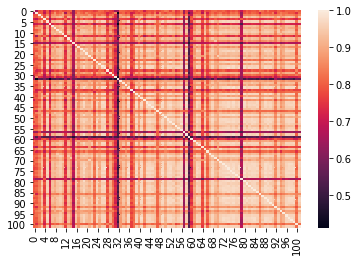

In [113]:
matrix = cosine_similarity(wiki_classphrases_zw.cpu().detach().numpy().T)
print(matrix.mean())
sn.heatmap(matrix)

In [114]:
wiki_classphrases_relative_perf = relative_per_class_performance(wiki_classphrases_czs[1], baseline_czs[1])
print(wiki_classphrases_relative_perf[1])

|-------------------------|--------------------|---------------------------|
|Class Name               |Relative Accuracy(%)|Difference in Num of Labels|
|==========================================================================|
|clematis                 |-100.0              |-17.0                      |
|-------------------------|--------------------|---------------------------|
|foxglove                 |-100.0              |-16.0                      |
|-------------------------|--------------------|---------------------------|
|rose                     |-100.0              |-14.0                      |
|-------------------------|--------------------|---------------------------|
|frangipani               |-100.0              |-12.0                      |
|-------------------------|--------------------|---------------------------|
|primula                  |-100.0              |-12.0                      |
|-------------------------|--------------------|---------------------------|

### Class names - Wikipedia Summaries

In [177]:
import wikipedia

wiki_summaries = {}
i=0
for c in dataset_obj.classes:
    d = c
    if "prince" in c:
        d = "prince's "
    if "ruby" in c:
        d = "crimson cattleya"
    if "barbeton" in c:
        d = c.replace("barbeton", "barberton")
    if "marigold" in c:
        d = "tagetes"
    if "black-eyed susan" in c:        
        d = "Rudbeckia hirta"
    if "silverbush" in c:
        d = "Convolvulus cneorum"
    if "windflower" in c:
        d = "Anemone"
    if "bee balm" in c:
        d = "monarda"
    wiki_summaries[c] = str(bytes(wikipedia.summary(d+" flower"),"utf8").decode("ascii", "ignore")).split(".")
with open('wiki_summaries.json',"w") as json_file:
    json.dump(wiki_summaries, json_file)

In [181]:
wiki_summary_templates = {c:[] for c in dataset_obj.classes}
for c in dataset_obj.classes:
    for i in range(len(wiki_summaries[c])):
        sen = wiki_summaries[c][i].replace("\n", "").replace("\"", "").replace("  ", " ").replace(" .",".").replace(" ,",",")
        sen = sen[:200]
        if c in sen:
            sen = sen.replace(c,"{}",1)
        else:
            sen = "{}: " + c
        wiki_summary_templates[c].append(sen)

In [182]:
def zeroshot_classifier(classnames, templates):
    i = 0
    m = 0
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [
                template.format(classname) for template in templates
            ]  # format with class
            for sen in wiki_summary_templates[classname]:
                i+=1
                try:
                    texts.append(sen)
                except:
                    m+=1
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
        print(i,m)
    return zeroshot_weights

wiki_summary_zw = zeroshot_classifier(dataset_obj.classes,templates)

wiki_summary_czs = clip_zero_shot(
    test_loader,
    dataset_obj.classes,
    wiki_summary_zw
)
print(wiki_summary_czs[0])

  0%|          | 0/102 [00:00<?, ?it/s]

797 0


  0%|          | 0/819 [00:00<?, ?it/s]

59.462759462759465


0.6838497239963442


<AxesSubplot:>

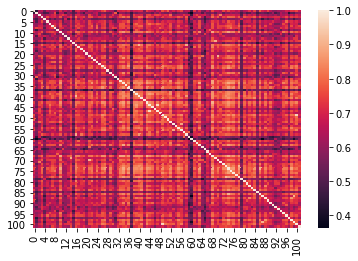

In [184]:
matrix = cosine_similarity(wiki_summary_zw.cpu().detach().numpy().T)
print(matrix.mean())
sn.heatmap(matrix)